## CHAPTER 2
---
# IMPUTING MISSING DATA

---
- Missing data refers to the absence of values for certain observations and is an unavoidable problem in most data sources. 
- Scikit-learn does not support missing values as input, so we need to remove observations with missing data or transform them into permitted values.
- The act of replacing missing data with statistical estimates of missing values is called **imputation**. 
- The goal of any imputation technique is to produce a complete dataset that can be used to train machine learning models. 
- There are multiple imputation techniques we can apply to our data. The choice of imputation technique we use will depend on 
    - whether the data is missing at random, 
    - the number of missing values, and 
    - the machine learning model we intend to use. 
- In this chapter, we will discuss several missing data imputation techniques.

## 2.1 Technical requirements and data prep

- Install 'Feature-engine' using pip: **pip install feature-engine** (Successfully installed feature-engine-0.5.15)
- Get the **Credit Approval Dataset**: the *crx.data* file was downloaded [here](http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/)

In [1]:
import random
import pandas as pd
import numpy as np
# feature-engine-0.5.15 was installed successfully

In [2]:
# let's load the data
data = pd.read_csv('data/crx.data', header=None)

# create variable names according to UCI Machine Learning Repo information
varnames = ['A'+str(s) for s in range(1,17)]

# add column names
data.columns = varnames

# replace ? by np.nan
data = data.replace('?', np.nan)

# re-cast some variables to the correct types 
data['A2'] = data['A2'].astype('float')
data['A14'] = data['A14'].astype('float')

# encode target to binary
data['A16'] = data['A16'].map({'+':1, '-':0})

data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [3]:
random.seed(9001)

values = set([random.randint(0, len(data)) for p in range(0, 100)])

for var in ['A3', 'A8', 'A9', 'A10']:
    data.loc[values, var] = np.nan
    
data.isnull().sum()

A1     12
A2     12
A3     92
A4      6
A5      6
A6      9
A7      9
A8     92
A9     92
A10    92
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

- To demonstrate the skills in this chapter, we introduced missing data at random in four additional variables in this dataset. 
- With random.randint(), we extracted random digits between 0 and the number of observations in the dataset, which is given by len(data), and 
- Used these digits as the indices of the dataframe where we introduce the NumPy NaN values
- Setting the seed at 9001 should allow to obtain the results provided in this chapter.

In [4]:
# save the data
path = 'data/credit_approval_uci.csv'
data.to_csv(path, index=False)

In [5]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [6]:
# find categorical variables
cat_cols = [c for c in data.columns if data[c].dtypes=='O']
data[cat_cols].head()

,A1,A4,A5,A6,A7,A9,A10,A12,A13
0,b,u,g,w,v,t,t,f,g
1,a,u,g,q,h,t,t,f,g
2,a,u,g,q,h,NaN,NaN,f,g
3,b,u,g,w,v,t,t,t,g
4,b,u,g,w,v,t,f,f,s


In [7]:
# find numerical variables
num_cols = [c for c in data.columns if data[c].dtypes!='O']
data[num_cols].head()

,A2,A3,A8,A11,A14,A15,A16
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,NaN,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


## 2.2 Removing observations with missing data

#### Complete Case Analysis:
Complete-case analysis (CCA), also called "list-wise deletion" of cases, consists in discarding observations where values in any of the variables are missing. Complete Case Analysis means literally analyzing only those observations for which there is information in all of the variables in the data set.

In [8]:
import pandas as pd

# to show all the columns of the dataframe in the notebeook
pd.set_option('display.max_columns', None)

In [9]:
# data is already loaded!
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [10]:
# inspect the percentage of missing values 
data.isnull().mean().sort_values(ascending=True)

A11    0.000000
A12    0.000000
A13    0.000000
A15    0.000000
A16    0.000000
A4     0.008696
A5     0.008696
A6     0.013043
A7     0.013043
A1     0.017391
A2     0.017391
A14    0.018841
A3     0.133333
A8     0.133333
A9     0.133333
A10    0.133333
dtype: float64

In [11]:
# create a complete case data set
data_cca = data.dropna()

print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases: {}'.format(len(data_cca)))

Number of total observations: 690
Number of observations with complete cases: 564


- To remove observations where data is missing in a subset of variables, we can execute data.dropna(subset=['A3', 'A4']). 
- To remove observations if data is missing in all the variables, we can execute data.dropna(how='all').

In [12]:
# indicate variables for which we would like the complete cases
cca = ['A1', 'A2', 'A6', 'A7', 'A14']
data_cca = data.dropna(subset=cca)

print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases: {}'.format(len(data_cca)))

Number of total observations: 690
Number of observations with complete cases: 653


In [13]:
# inspect the percentage of missing values in data_cca
data_cca.isnull().mean().sort_values(ascending=True)

A1     0.000000
A2     0.000000
A4     0.000000
A5     0.000000
A6     0.000000
A7     0.000000
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.000000
A15    0.000000
A16    0.000000
A3     0.136294
A8     0.136294
A9     0.136294
A10    0.136294
dtype: float64

## 2.3 Performing mean or median imputation

Mean or median imputation consists in replacing all occurrences of missing values (NaN) in a variable 
- by the mean (if the variable has a Gaussian distribution) or 
- by the median (if the variable has a skewed distribution).

In [14]:
import pandas as pd

# to split the data sets
from sklearn.model_selection import train_test_split

# to impute missing data with sklearn
from sklearn.impute import SimpleImputer

# to impute missing data with feature-engine
from feature_engine.missing_data_imputers import MeanMedianImputer

In [15]:
# data is already loaded
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [16]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In mean and median imputation, the mean or median values should be calculated using the variables in the train set; therefore, we separated the data into train and test sets and their respective targets. 

In [17]:
# find the percentage of missing data per variable
X_train.isnull().mean()

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64

#### Mean or median imputation with Pandas

In [18]:
# replace NaN in the following numerical variables
for var in ['A2', 'A3', 'A8', 'A11', 'A15']:
    value = X_train[var].median()
    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)
    
# check absence of missing values in imputed variables
X_train[['A2', 'A3', 'A8', 'A11', 'A15']].isnull().sum()

A2     0
A3     0
A8     0
A11    0
A15    0
dtype: int64

#### Mean or median imputation with Scikit-Learn

In [19]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data[['A2', 'A3', 'A8', 'A11', 'A15']], data['A16'],
    test_size=0.3, random_state=0)

# create a median imputation object with SimpleImputer
imputer = SimpleImputer(strategy='median')

# let's fit the imputer to the train set
imputer.fit(X_train)

# we can look at the learned medians:
imputer.statistics_

array([28.835,  2.75 ,  1.   ,  0.   ,  6.   ])

The imputer stores median values in the statistics_ attribute, as shown in the above output

In [20]:
# and now we impute the train and test sets
# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# check that missing values were removed
pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

#### Mean or median imputation with Feature-engine

In [21]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

# let's create a median imputer
median_imputer = MeanMedianImputer(imputation_method='median',
                                   variables=['A2', 'A3', 'A8', 'A11', 'A15'])
median_imputer.fit(X_train)

MeanMedianImputer(variables=['A2', 'A3', 'A8', 'A11', 'A15'])

In [22]:
# let's inspect the dictionary with the mappings for each variable
median_imputer.imputer_dict_

{'A2': 28.835, 'A3': 2.75, 'A8': 1.0, 'A11': 0.0, 'A15': 6.0}

In [23]:
# transform the data
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

# check that null values were replaced
X_train[['A2', 'A3', 'A8', 'A11', 'A15']].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
A15    0.0
dtype: float64

#### Mean or median imputation with Scikit-Learn selecting features to impute

In [24]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [25]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

# first we need to make a list with the numerical vars
numeric_features_mean = ['A2', 'A3', 'A8', 'A11', 'A15']

# then we instantiate the imputer within a pipeline
numeric_mean_imputer = Pipeline(steps=[('imputer', 
                                        SimpleImputer(strategy='mean'))
                                      ])
# then we put the features list and the imputer in the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('mean_imputer', numeric_mean_imputer, numeric_features_mean)
    ], remainder='passthrough')

# now we fit the preprocessor
preprocessor.fit(X_train)

# and now we impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

# Note that Scikit-Learn transformers return NumPy arrays!!
X_train

array([[46.08, 3.0, 2.375, ..., 't', 'g', 396.0],
       [15.92, 2.875, 0.085, ..., 'f', 'g', 120.0],
       [36.33, 2.125, 0.085, ..., 'f', 'g', 50.0],
       ...,
       [19.58, 0.665, 1.665, ..., 'f', 'g', 220.0],
       [22.83, 2.29, 2.29, ..., 't', 'g', 140.0],
       [40.58, 3.29, 3.5, ..., 't', 's', 400.0]], dtype=object)

In [26]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,46.08,3,2.375,8,4159,a,u,g,c,v,t,t,t,g,396
1,15.92,2.875,0.085,0,0,a,u,g,q,v,f,f,f,g,120
2,36.33,2.125,0.085,1,1187,b,y,p,w,v,t,t,f,g,50
3,22.17,0.585,0,0,0,b,y,p,ff,ff,f,f,f,g,100
4,57.83,7.04,14,6,1332,b,u,g,m,v,t,t,t,g,360


Scikit-learn's SimpleImputer() imputes all the variables in the dataset but, with scikit-learn's ColumnTransformer(), we can select specific variables we want to impute.

## 2.4 Implementing mode or frequent category imputation

- Mode imputation consists of replacing missing values with the mode. 
- We normally use this procedure on categorical variables, hence the frequent category imputation name. 
- Frequent categories are estimated using the train set and then used to impute values in train, test, and future datasets. 
- Thus, we need to learn and store these parameters, which we can do using scikit-learn and Feature-engine's transformers

In [27]:
import pandas as pd

# to split the data sets
from sklearn.model_selection import train_test_split

# to impute missing data with sklearn
from sklearn.impute import SimpleImputer

# to impute missing data with feature-engine
import feature_engine.missing_data_imputers as mdi

In [28]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [29]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In [30]:
# find the percentage of missing data within those variables
X_train.isnull().mean()

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64

#### Frequent category imputation with Pandas

In [31]:
# replace NaN in some categorical variables
for var in ['A4', 'A5', 'A6', 'A7']:
    value = X_train[var].mode()[0]
    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)
    
# check absence of missing values
X_train[['A4', 'A5', 'A6', 'A7']].isnull().sum()

A4    0
A5    0
A6    0
A7    0
dtype: int64

#### Frequent category imputation with Scikit-Learn

In [32]:
# let's separate into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=0.3, random_state=0)

# create a frequent category imputation object with SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# we fit the imputer to the train set
# the imputer will learn the mode of all variables
imputer.fit(X_train)

# we can look at the learnt modes:
imputer.statistics_

array(['u', 'g', 'c', 'v'], dtype=object)

In [33]:
# and now we impute the train and test set
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

#### Frequent category imputation with Feature-engine (had issues)

#### Frequent category imputation with Sklearn selecting features to impute

In [34]:
import pandas as pd

# objects to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [35]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

# first we make a lists with the features to be imputed
categoric_features = ['A4', 'A5', 'A6', 'A7']

# then we instantiate the imputer within a pipeline
categoric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# then we put the features list and the imputer together using the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('frequent_imputer', categoric_imputer, categoric_features)
    ], remainder='passthrough')

# now we fit the preprocessor
preprocessor.fit(X_train)

# and now we can impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,u,g,c,v,a,46.08,3,2.375,t,t,8,t,g,396,4159
1,u,g,q,v,a,15.92,2.875,0.085,f,f,0,f,g,120,0
2,y,p,w,v,b,36.33,2.125,0.085,t,t,1,f,g,50,1187
3,y,p,ff,ff,b,22.17,0.585,0,f,f,0,f,g,100,0
4,u,g,m,v,b,57.83,7.04,14,t,t,6,t,g,360,1332


## 2.5 Replacing missing values with an arbitrary number

- Arbitrary number imputation consists of replacing missing values with an arbitrary value.
- Some commonly used values include 999, 9999, or -1 for positive distributions. 
- This method is suitable for numerical variables. 
- A similar method for categorical variables will be discussed in the "Capturing missing values in a bespoke category" section.
- When replacing missing values with an arbitrary number, we need to be careful not to select a value close to the mean or the median, or any other common value of the distribution.
- Arbitrary number imputation can be used when data is not missing at random, when we are building non-linear models, and when the percentage of missing data is high. 
- This imputation technique distorts the original variable distribution.

In [36]:
import pandas as pd

# to split the data sets
from sklearn.model_selection import train_test_split

# to impute missing data with sklearn
from sklearn.impute import SimpleImputer

In [37]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [38]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In [39]:
# find the percentage of missing data per variable
X_train.isnull().mean()

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64

#### Arbitrary imputation with pandas

In [40]:
# find the maximum value per variable
X_train[['A2','A3', 'A8', 'A11']].max()

A2     76.750
A3     26.335
A8     20.000
A11    67.000
dtype: float64

In [41]:
# replace NaN with 99 in indicated numerical variables
for var in ['A2','A3', 'A8', 'A11']:    
    X_train[var].fillna(99, inplace=True)
    X_test[var].fillna(99, inplace=True)
    
# check absence of missing values
X_train[['A2','A3', 'A8', 'A11']].isnull().sum()

A2     0
A3     0
A8     0
A11    0
dtype: int64

#### Arbitrary imputation with Scikit-learn

In [42]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data[['A2', 'A3', 'A8', 'A11']],
    data['A16'],
    test_size=0.3,
    random_state=0)

# create an instance of the simple imputer
imputer = SimpleImputer(strategy='constant', fill_value=99)

# we fit the imputer to the train set
imputer.fit(X_train)

# we can look at the constant values:
imputer.statistics_

array([99., 99., 99., 99.])

In [43]:
# and now we impute the train and test set
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# check that missing values were removed
pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

#### Arbitrary imputation imputation with Sklearn selecting features to impute

In [44]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [45]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1),data['A16' ], test_size=0.3, random_state=0)

# first we need to make a list with the numerical vars
features_arbitrary = ['A2', 'A3', 'A8', 'A11']
features_mean = ['A15']

# then we instantiate the imputer within a pipeline
arbitrary_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=99))])
mean_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

# then we put the features list and the imputer in the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('arbitrary_imputer', arbitrary_imputer, features_arbitrary),
    ('mean_imputer', mean_imputer, features_mean)
    ], remainder='passthrough')

# now we fit the preprocessor
preprocessor.fit(X_train)

# and now we impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,46.08,3,2.375,8,4159,a,u,g,c,v,t,t,t,g,396
1,15.92,2.875,0.085,0,0,a,u,g,q,v,f,f,f,g,120
2,36.33,2.125,0.085,1,1187,b,y,p,w,v,t,t,f,g,50
3,22.17,0.585,0,0,0,b,y,p,ff,ff,f,f,f,g,100
4,57.83,7.04,14,6,1332,b,u,g,m,v,t,t,t,g,360


In [46]:
# check that missing values were removed
pd.DataFrame(X_train).isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      4
6      4
7      4
8      4
9      4
10    68
11    68
12     0
13     0
14     7
dtype: int64

## 2.6 Capturing missing values into a new category

Missing data in categorical variables can be treated as a different category, so it is common to replace missing values with the Missing string.

In [47]:
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

# to impute missing data with sklearn
from sklearn.impute import SimpleImputer

In [48]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [49]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

#### Adding a 'Missing' category with pandas

In [50]:
# replace NA in some categorical variables
for var in ['A4', 'A5', 'A6', 'A7']:

    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)
    
# check absence of missing values
X_train[['A4', 'A5', 'A6', 'A7']].isnull().sum()

A4    0
A5    0
A6    0
A7    0
dtype: int64

#### Adding a 'Missing' category with Scikit-learn

In [51]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=0.3, random_state=0)

# create an instance of the simple imputer
imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# we fit the imputer to the train set
imputer.fit(X_train)

# we can look at the new category:
imputer.statistics_

array(['Missing', 'Missing', 'Missing', 'Missing'], dtype=object)

In [52]:
# and now we impute the train and test set
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

#### Adding a 'Missing' category with Sklearn selecting features to impute

In [53]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the datasets
from sklearn.model_selection import train_test_split

In [54]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

# first we make a lists with the features to be imputed
features_arbitrary = ['A4', 'A5']
features_mode = ['A6', 'A7']

# then we instantiate the imputer within a pipeline
arbitrary_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing'))])

mode_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

# then we put the features list and the imputers in the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('arbitrary_imputer', arbitrary_imputer, features_arbitrary),
    ('mean_imputer', mode_imputer, features_mode)
    ], remainder='passthrough')

# now we fit the preprocessor
preprocessor.fit(X_train)

# and now we can impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,u,g,c,v,a,46.08,3,2.375,t,t,8,t,g,396,4159
1,u,g,q,v,a,15.92,2.875,0.085,f,f,0,f,g,120,0
2,y,p,w,v,b,36.33,2.125,0.085,t,t,1,f,g,50,1187
3,y,p,ff,ff,b,22.17,0.585,0,f,f,0,f,g,100,0
4,u,g,m,v,b,57.83,7.04,14,t,t,6,t,g,360,1332


## 2.7 Replacing missing values with a value at the end of the distribution

- Replacing missing values with a value at the end of the variable distribution is equivalent to replacing them with an arbitrary value, but instead of identifying the arbitrary values manually, these values are automatically selected as those at the very end of the variable distribution. 
- The values that are used to replace missing information are estimated using the mean plus or minus three times the standard deviation if the variable is normally distributed, or the inter-quartile range (IQR) proximity rule otherwise. 
- According to the IQR proximity rule, missing values will be replaced with the 75th quantile + (IQR * 1.5) at the right tail or by the 25th quantile - (IQR * 1.5) at the left tail. 
- The IQR is given by the 75th quantile - the 25th quantile.
- Some will also identify the minimum or maximum values of the variable and replace missing data as a factor of these values, for example, three times the maximum value.

In [55]:
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

In [56]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


#### End-tail imputation with Pandas

In [57]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In [58]:
# find the percentage of missing data per variable
variables = ['A2', 'A3', 'A8', 'A11', 'A15']
X_train[variables].isnull().mean()

A2     0.022774
A3     0.140787
A8     0.140787
A11    0.000000
A15    0.000000
dtype: float64

In [59]:
# replace NaN in indicated numerical variables using inter-quantal range proximity rule 
for var in variables:
    IQR = X_train[var].quantile(0.75) - X_train[var].quantile(0.25)
    value = X_train[var].quantile(0.75) + 1.5 * IQR

    X_train[var] = X_train[var].fillna(value)
    X_test[var] = X_test[var].fillna(value)

# check absence of missing values
X_train[variables].isnull().mean()

A2     0.0
A3     0.0
A8     0.0
A11    0.0
A15    0.0
dtype: float64

## 2.8 Implementing random sample imputation

- Random sampling imputation consists of extracting random observations from the pool of available values in the variable. 
- Random sampling imputation preserves the original distribution, which differs from the other imputation techniques we've discussed in this chapter and is suitable for numerical and categorical variables alike.

In [60]:
import pandas as pd

# to split the data sets
from sklearn.model_selection import train_test_split

In [61]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [62]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

#### Random Sample imputation with Pandas

In [63]:
# extract a random sample (as many values as missing values in the variable)
number_missing_values = X_train['A2'].isnull().sum()
number_missing_values

11

In [64]:
# extract a random sample (as many values as missing values in the variable)
random_sample_train = X_train['A2'].dropna().sample(number_missing_values, random_state=0)

# re-index the random sample so that we can join it to our original data
random_sample_train.index = X_train[X_train['A2'].isnull()].index
random_sample_train.index

Int64Index([97, 500, 329, 83, 254, 608, 445, 450, 515, 286, 86], dtype='int64')

In [65]:
# replace the missing values
X_train.loc[X_train['A2'].isnull(), 'A2'] = random_sample_train

X_train['A2'].isnull().sum()

0

In [66]:
# repeat in a loop for the rest of the variables
# and for both train and test set

variables = ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']
for var in variables:
    
    # extract a random sample
    random_sample_train = X_train[var].dropna().sample(
        X_train[var].isnull().sum(), random_state=0)

    random_sample_test = X_train[var].dropna().sample(
        X_test[var].isnull().sum(), random_state=0)

    # re index the random sample
    random_sample_train.index = X_train[X_train[var].isnull()].index
    random_sample_test.index = X_test[X_test[var].isnull()].index

    # replace the NA 
    X_train.loc[X_train[var].isnull(), var] = random_sample_train
    X_test.loc[X_test[var].isnull(), var] = random_sample_test
    
# check missing data
X_train[variables].isnull().sum()

A1    0
A3    0
A4    0
A5    0
A6    0
A7    0
A8    0
dtype: int64

To perform random sample imputation using Pandas:
- We calculated the number of missing values in the variable using pandas isnull(), followed by sum()
- Next, we used Pandas dropna() to drop missing information from the original variable in the train set so that we extracted values from observations with data using pandas sample(). 
- We extracted as many observations as there was missing data in the variable to impute. 
- Next, we re-indexed the pandas Series with the randomly extracted values so that we could assign those to the missing observations in the original dataframe. 
- Finally, we replaced the missing values with values extracted at random using pandas' loc, which takes the location of the rows with missing data and the name of the column to which the new values are to be assigned as arguments.

## 2.9 Adding a missing value indicator variable

- A missing indicator is a binary variable that specifies whether a value was missing for an observation (1) or not (0). 
- It is common practice to replace missing observations by the mean, median, or mode while flagging those missing observations with a missing indicator, thus covering two angles: 
    - If the data was missing at random, this would be contemplated by the mean, median, or mode imputation, and 
    - If it wasn't, this would be captured by the missing indicator. 
- In this section, we will learn how to add missing indicators using NumPy and Scikit-Learn.

In [67]:
import pandas as pd
import numpy as np

# to split the data sets
from sklearn.model_selection import train_test_split

In [68]:
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [69]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

#### Add missing indicator with Pandas

In [70]:
# add missing indicator
for var in ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)
    
# check the new missing indicator variables
X_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_NA,A3_NA,A4_NA,A5_NA,A6_NA,A7_NA,A8_NA
596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159,0,0,0,0,0,0,0
303,a,15.92,2.875,u,g,q,v,0.085,f,f,0,f,g,120.0,0,0,0,0,0,0,0,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,0,0,0,0,0,0,0
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,0,0,0,0,0,0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,0,0,0,0,0,0,0


In [71]:
# the mean of the missing indicator should be the same as the 
# percentage of missing values in the original variable
X_train['A3'].isnull().mean(), X_train['A3_NA'].mean()

(0.14078674948240166, 0.14078674948240166)

To add missing indicators using NumPy, 
- We used the where() method, which created a new vector after scanning all the observations in a variable, assigning the value of 1 if there was a missing observation or 0 otherwise. 
- We captured the indicators in columns with the name of the original variable, plus _NA.

#### Adding missing indicator with Scikit-Learn

In [72]:
import pandas as pd
from sklearn.impute import MissingIndicator
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

indicator = MissingIndicator(error_on_new=True, features='missing-only')
indicator.fit(X_train)  

# we can see the features with na:
# the result shows the column index in the NumPy array
indicator.features_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13], dtype=int64)

In [74]:
# with Sklearn we need to join the missing indicators dataframe
# to the original X_train

# let's create a column name for each of the new MissingIndicators
indicator_cols = [c+'_NA' for c in X_train.columns[indicator.features_]]

# and now let's concatenate the original dataset with the missing indicators
X_train = pd.concat([
    X_train.reset_index(),
    pd.DataFrame(indicator.transform(X_train), columns = indicator_cols)],
    axis=1)

X_train.head()

,index,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_NA,A2_NA,A3_NA,A4_NA,A5_NA,A6_NA,A7_NA,A8_NA,A9_NA,A10_NA,A14_NA
0,596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159,False,False,False,False,False,False,False,False,False,False,False
1,303,a,15.92,2.875,u,g,q,v,0.085,f,f,0,f,g,120.0,0,False,False,False,False,False,False,False,False,False,False,False
2,204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,False,False,False,False,False,False,False,False,False,False,False
3,351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,False,False,False,False,False,False,False,False,False,False,False
4,118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,False,False,False,False,False,False,False,False,False,False,False


- To add missing indicators with scikit-learn, we created an instance of MissingIndicator() so that we only added indicators to variables with missing data. 
- With the fit() method, the transformer identified variables with missing values. 
- With transform(), it returned a NumPy array with binary indicators, which we captured in a dataframe and then concatenated to the original dataframe.

We can add missing indicators using scikit-learn's SimpleImputer() by setting the add_indicator argument to True. For example, imputer = SimpleImputer(strategy=’mean’, add_indicator=True) will return a NumPy array with missing indicators, plus the missing values in the original variables were replaced by the mean after using the fit() and transform() methods.

## 2.10 Performing multivariate imputation by chained equations

Multivariate imputation by chained equations (**MICE**) is a multiple imputation technique that models each variable with
missing values as a function of the remaining variables and uses that estimate for imputation. MICE has the following basic steps:
1. A simple univariate imputation is performed for every variable with missing data, for example, median imputation.
2. One specific variable is selected, say, var_1, and the missing values are set back to missing.
3. A model that's used to predict var_1 is built based on the remaining variables in the dataset.
4. The missing values of var_1 are replaced with the new estimates.
5. Repeat step 2 to step 4 for each of the remaining variables.

Once all the variables have been modeled based on the rest, a cycle of imputation is concluded. Step 2 to step 4 are performed multiple times, typically 10 times, and the imputation values after each round are retained. The idea is that, by the end of the cycles, the distribution of the imputation parameters should have converged. Each variable with missing data can be modeled based on the remaining variable by using multiple approaches, for example, linear regression, Bayes, decision trees, k-nearest neighbors, and random forests.

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [76]:
# load data with numerical variables
variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = data[variables]
data.head()

,A2,A3,A8,A11,A14,A15,A16
0,30.83,0.000,1.25,1,202.0,0,1
1,58.67,4.460,3.04,6,43.0,560,1
2,24.50,NaN,NaN,0,280.0,824,1
3,27.83,1.540,3.75,5,100.0,3,1
4,20.17,5.625,1.71,0,120.0,0,1


In [77]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [78]:
# find the percentage of missing data within those variables
X_train.isnull().mean()

A2     0.022774
A3     0.140787
A8     0.140787
A11    0.000000
A14    0.014493
A15    0.000000
dtype: float64

In [79]:
# let's create a MICE imputer using Bayes regression as estimator
imputer = IterativeImputer(estimator= BayesianRidge(),
                           max_iter=10, random_state=0)
imputer.fit(X_train)

# transform the data - replace the missing values
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

pd.DataFrame(X_train).isnull().mean()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
dtype: float64

**Using IterativeImputer() from scikit-learn, we can model variables using multiple algorithms, such as:** 
- Bayes, 
- k-nearest neighbors, 
- decision trees (*removed*), and 
- random forests.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [82]:
imputer_bayes = IterativeImputer(estimator=BayesianRidge(),
                                 max_iter=10,
                                 random_state=0)
imputer_bayes.fit(X_train)

IterativeImputer(estimator=BayesianRidge(), random_state=0)

In [83]:
imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5),
                                 max_iter=10,
                                 random_state=0)
imputer_knn.fit(X_train)

IterativeImputer(estimator=KNeighborsRegressor(), random_state=0)

In [84]:
imputer_missForest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10),
                                 max_iter=20,
                                 random_state=0)
imputer_missForest.fit(X_train)

IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10), max_iter=20,
                 random_state=0)

**DecisionTreeRegressor** returned 'ConvergenceWarning' even after playing with max_iter number. I had to be removed

In [85]:
X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)

predictors = [var for var in variables if var !='A16']

In [86]:
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)

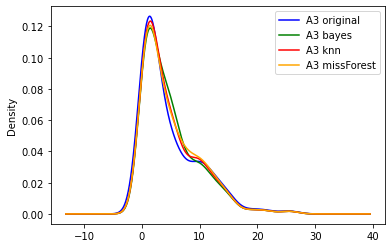

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)

X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')

# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.show()

In the preceding plot, we can see that the different algorithms return slightly different distributions of the original variable.

## 2.11 Assembling an imputation pipeline with scikit-learn

- Datasets often contain a mix of numerical and categorical variables. 
- In addition, some variables may contain a few missing data points, while others will contain quite a big proportion. 
- The mechanisms by which data is missing may also vary among variables.
- Thus, we may wish to perform different imputation procedures for different variables. 
- In this section, we will learn how to perform different imputation procedures for different feature subsets using scikit-learn.

In [88]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [89]:
# load data
path = 'data/credit_approval_uci.csv'
data = pd.read_csv(path)
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,NaN,u,g,q,h,NaN,NaN,NaN,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [90]:
# let's separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In [91]:
# find categorical variables
cat_cols = [c for c in data.columns if data[c].dtypes=='O']
data[cat_cols].isnull().mean().sort_values()

A12    0.000000
A13    0.000000
A4     0.008696
A5     0.008696
A6     0.013043
A7     0.013043
A1     0.017391
A9     0.133333
A10    0.133333
dtype: float64

In [92]:
# find numerical variables
num_cols = [c for c in data.columns if data[c].dtypes!='O']
data[num_cols].isnull().mean().sort_values()

A11    0.000000
A15    0.000000
A16    0.000000
A2     0.017391
A14    0.018841
A3     0.133333
A8     0.133333
dtype: float64

In [93]:
# find the percentage of missing data within those variables
X_train.isnull().mean()

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64

In [94]:
# we make a list with the numerical vars
features_num_arbitrary = ['A3', 'A8']
features_num_median = ['A2', 'A14']

# we make a list with the categorical vars
features_cat_frequent = ['A4', 'A5', 'A6', 'A7']
features_cat_missing = ['A1', 'A9', 'A10']

In [95]:
# we instantiate each imputer within a pipeline
imputer_num_arbitrary = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=99)),
])
imputer_num_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
imputer_cat_frequent = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])
imputer_cat_missing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
])

In [96]:
# then we put the features list and imputers in the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('imp_num_arbitrary', imputer_num_arbitrary, features_num_arbitrary),
    ('imp_num_median', imputer_num_median, features_num_median),
    ('imp_cat_frequent', imputer_cat_frequent, features_cat_frequent),
    ('imp_cat_missing', imputer_cat_missing, features_cat_missing),
    ], remainder='passthrough')

In [97]:
# now we fit the preprocessor
preprocessor.fit(X_train)

# and now we impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [98]:
pd.DataFrame(X_train).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [99]:
pd.DataFrame(X_test).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
dtype: int64

In [100]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3,2.375,46.08,396,u,g,c,v,a,t,t,8,t,g,4159
1,2.875,0.085,15.92,120,u,g,q,v,a,f,f,0,f,g,0
2,2.125,0.085,36.33,50,y,p,w,v,b,t,t,1,f,g,1187
3,0.585,0,22.17,100,y,p,ff,ff,b,f,f,0,f,g,0
4,7.04,14,57.83,360,u,g,m,v,b,t,t,6,t,g,1332


The beauty of this procedure is that we can save the preprocessor in one object to perpetuate all the parameters that are learned by the different transformers.